In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

from jaxili.model import ConditionalMAF

import matplotlib.pyplot as plt
import seaborn as sns

from getdist import MCSamples, plots

2024-08-07 11:34:19.300499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
jax.devices()

[cuda(id=0)]

# 2D Gaussian Means

In this notebook, we want to reproduce the results from Schmitt et al. (2024) on a toy model where the poserior is analytic. The data generating process is the following:

\begin{align}
x_k \sim \mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}), \quad \boldsymbol{\mu} \sim \mathcal{N}(\boldsymbol{\mu}| \boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0)
\end{align}

The data generating process used by default will have a 0 mean and a variance equal to the identity. We want to explore misspecification coming from different sources. Firts coming from the prior by modifying the mean and scaling the covariance (identity matrix). Second, from the simulator by scaling the covariance of the simulator. Finally, we can add noise following the law:

$$
x_k \sim \lambda . \rm{Beta}(2, 5) + (1-\lambda).\mathcal{N}(\boldsymbol{\mu}, \mathbb{I})
$$

### Implementation of the different priors and simulator

In [3]:
def prior(rng, n):
    """
    Sample n points from a standard unit 2D Gaussian distribution.
    n: number of samples
    """
    mean = jnp.zeros((2,))
    cov = jnp.eye(2)
    return jax.random.multivariate_normal(rng, mean=mean, cov=cov, shape=(n,))

def prior_mean_misspecified(rng, n, mean):
    """
    Sample n points from a 2D Gaussian distribution with a misspecified mean.
    n: number of samples
    mean: true mean of the distribution
    """
    cov = jnp.eye(2)
    return jax.random.multivariate_normal(rng, mean=mean, cov=cov, shape=(n,))

def prior_cov_misspecified(rng, n, scaling):
    """
    Sample n points from a 2D Gaussian distribution with a misspecified covariance matrix.
    n: number of samples
    scaling: scaling factor for the covariance matrix
    """
    mean = jnp.zeros((2,))
    cov = scaling * jnp.eye(2)
    return jax.random.multivariate_normal(rng, mean=mean, cov=cov, shape=(n,))

def simulator(rng, n, params):
    """
    Simulate n points from a 2D Gaussian distribution.
    n: number of samples
    params: mean of the distribution
    """
    mean, cov= params, jnp.eye(2)
    return jax.random.multivariate_normal(rng, mean=mean, cov=cov, shape=(n,))

def simulator_cov_misspecified(rng, n, params, scaling):
    """
    Simulate n points from a 2D Gaussian distribution with a misspecified covariance matrix.
    n: number of samples
    params: mean of the distribution
    scaling: scaling factor for the covariance matrix
    """
    mean, cov = params, scaling * jnp.eye(2)
    return jax.random.multivariate_normal(rng, mean=mean, cov=cov, shape=(n,))

def simulator_noise_misspecified(rng, n, params, noise_level):
    """
    Simulate n points from a 2D Gaussian distribution with additive noise.
    n: number of samples
    params: mean of the distribution
    noise_level: parameters tuning the amount of noise (in  (0, 1))
    """
    assert 0 <= noise_level <= 1
    mean, cov = params, jnp.eye(2)
    z = jax.random.bernoulli(rng, noise_level, shape=(n,))
    z = jnp.hstack([z[:, None], z[:, None]])
    samples = jnp.where(
        z==1, jax.random.beta(rng, 2, 5, shape=(n, 2)), jax.random.multivariate_normal(rng, mean=mean, cov=cov, shape=(n,))
    )
    return samples

def posterior_distribution(mu, x):
    """
    Posterior density function of the well-specified model.
    mu: parameters
    x: observed data
    """
    mu = mu.squeeze()
    x = x.squeeze()
    normalization = 1/jnp.pi*jnp.exp(-0.25*(jnp.dot(x, x)))
    return normalization * jnp.exp(-0.5*(jnp.dot(mu, mu)+jnp.dot(x-mu, x-mu)))

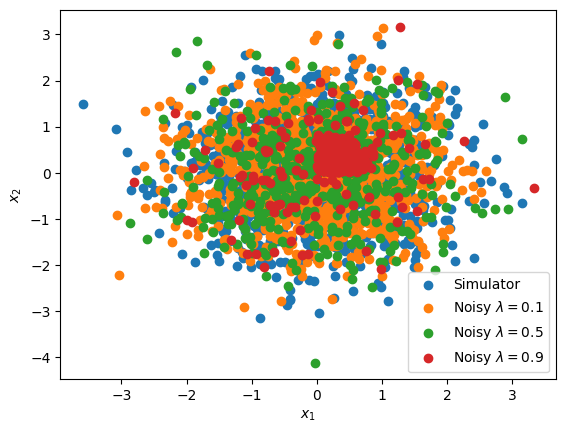

In [4]:
master_key = jax.random.PRNGKey(0)
key, master_key = jax.random.split(master_key)

samples_simulator = simulator(
    key, 1000, jnp.array([0.0, 0.0])
)

key, master_key = jax.random.split(master_key)
samples_noisy_point1 = simulator_noise_misspecified(
    key, 1000, jnp.array([0.0, 0.0]), 0.1
)

key, master_key = jax.random.split(master_key)
samples_noisy_point5 = simulator_noise_misspecified(
    key, 1000, jnp.array([0.0, 0.0]), 0.5
)

key, master_key = jax.random.split(master_key)
samples_noisy_point9 = simulator_noise_misspecified(
    key, 1000, jnp.array([0.0, 0.0]), 0.9
)

plt.figure()

plt.scatter(samples_simulator[:, 0], samples_simulator[:, 1], label="Simulator")
plt.scatter(samples_noisy_point1[:, 0], samples_noisy_point1[:, 1], label=r"Noisy $\lambda=0.1$")
plt.scatter(samples_noisy_point5[:, 0], samples_noisy_point5[:, 1], label=r"Noisy $\lambda=0.5$")
plt.scatter(samples_noisy_point9[:, 0], samples_noisy_point9[:, 1], label=r"Noisy $\lambda=0.9$")
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

### Training the network

The goal of our approach is to minimize the following criterion:

$$
\psi^*, \phi^* = \underset{\psi, \phi}{\rm{argmin}}\mathbb{E}_{p(\theta, x|\mathcal{M})}\left[-\log q_\phi(\theta|h_{\psi}(x), \mathcal{M}) \right]
+ \gamma \mathbb{MMD}^2\left[p(h_\psi(x)|\mathcal{M})||\mathcal{N}(0, \mathbb{I}) \right]
$$

where we introduce a hyperparameter $\gamma$ to controle the relative weight of the Maximum Mean Discrepancy (MMD). This loss aims at minimizing the Kullback-Leibler divergence via the negative log-likelihood while, at the same time, compressing data to a unit gaussian.

The Maximum Mean Discrepancy writes:

$$
\mathbb{MMD}^2[p^*(x)||p(x|\mathcal{M})] = \mathbb{E}_{x,x'\sim p^*(x)}[\kappa(x,x')]+\mathbb{E}_{x,x'\sim p(x|\mathcal{M})}[\kappa(x,x')] - 2\mathbb{E}_{x \sim p^*(x);x' \sim p(x|\mathcal{M})}[\kappa(x,x')]
$$

where $\kappa(.,.)$ is a positive-definite kernel. We can estimate the MMD based on finite samples and its analytic value equals zero if and only if the two densities are equal. We use sums of Gaussian kernels with different widths $\sigma_i$ as an exstablished and flexible universal kernel.

We first implement a simple feed-forward compressor to send the output of our simulator in a compressed space of size $2$ where it will be gaussian distributed under the MMD criteria.

In [5]:
class MLPCompressor(nn.Module):
    hidden_size: list
    output_size: int

    @nn.compact
    def __call__(self, x):
        for size in self.hidden_size:
            x = nn.Dense(size)(x)
            x = nn.relu(x)
        x = nn.Dense(self.output_size)(x)
        return x

In [6]:
hidden_size = [128, 128]
output_size = 2

mlp_compressor = MLPCompressor(hidden_size, output_size)

In [7]:
params_comp = mlp_compressor.init(key, jnp.ones((2,2)))
print(mlp_compressor.tabulate(key, jnp.ones((2,))))


                             MLPCompressor Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module        ┃ inputs       ┃ outputs      ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLPCompressor │ float32[2]   │ float32[2]   │                      │
├─────────┼───────────────┼──────────────┼──────────────┼──────────────────────┤
│ Dense_0 │ Dense         │ float32[2]   │ float32[128] │ bias: float32[128]   │
│         │               │              │              │ kernel:              │
│         │               │              │              │ float32[2,128]       │
│         │               │              │              │                      │
│         │               │              │              │ 384 (1.5 KB)         │
├─────────┼───────────────┼──────────────┼──────────────┼──────────────────────┤
│ Dense_1 │ Dense         │

For the normalizing flow, we will use a Masked Autoregressive Flow (MAF) implemented in JaxILI (https://github.com/sachaguer/jaxili/tree/develop).

In [8]:
n_in = 2
n_cond = 2
n_layers = 5
layers = [128, 128]
activation = jax.nn.relu
use_reverse = True
seed = 42


nf_npe = ConditionalMAF(
    n_in=n_in,
    n_cond=n_cond,
    n_layers=n_layers,
    layers=layers,
    activation=activation,
    use_reverse=use_reverse,
    seed=seed
)

params_nf = nf_npe.init(key, jnp.ones((2,2)), jnp.ones((2,2)), method='log_prob')

In [9]:
class NF_MLPCompressor(nn.Module):
    mlp_compressor: nn.Module
    nf_npe: nn.Module
    mlp_hparams: dict
    nf_hparams: dict

    def setup(self):
        self.mlp_compressor_nn = self.mlp_compressor(**self.mlp_hparams)
        self.nf_npe_nn = self.nf_npe(**self.nf_hparams)

    def __call__(self, x, theta):
        z = self.mlp_compressor_nn(x)
        log_prob = self.nf_npe_nn.log_prob(theta, z)
        return log_prob
    
    def compress(self, x):
        z = self.mlp_compressor_nn(x)
        return z
    
    def log_prob_from_compressed(self, theta, z):
        log_prob = self.nf_npe_nn.log_prob(theta, z)
        return log_prob
    
    def sample(self, x, rng, n_samples):
        z = self.mlp_compressor_nn(x)
        samples = self.nf_npe_nn.sample(z, n_samples, rng)
        return samples

mlp_hparams = {
    'hidden_size': [128, 128],
    'output_size': 2
}

nf_hparams = {
    'n_in': 2,
    'n_cond': 2,
    'n_layers': 5,
    'layers': [128, 128],
    'activation': jax.nn.relu,
    'use_reverse': True,
    'seed': 42
}

nf_mlp_compressor = NF_MLPCompressor(
    MLPCompressor,
    ConditionalMAF,
    mlp_hparams,
    nf_hparams
)

params_nf_mlp = nf_mlp_compressor.init(key, jnp.ones((2,2)), jnp.ones((2,2)))

In [10]:
nf_mlp_compressor.apply(params_nf_mlp, jnp.ones((2,2)), jnp.ones((2,2)))

Array([-2.838093, -2.838093], dtype=float32)

We will use `optax` to perform the optimisation.

In [12]:
total_steps = 20_000
learning_rate = 5e-4
warmup  = 0.1
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=1e-4,
    peak_value=learning_rate,
    end_value=0.01*learning_rate,
    warmup_steps=warmup,
    decay_steps = int(total_steps * 0.9)
)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_scheduler)
)

opt_state = optimizer.init(params_nf_mlp)

### Definition of the loss and update functions

The loss function has been introduced above and will be implemented here.

In [14]:
def loss_nll(params, theta, x):
    log_prob = nf_mlp_compressor.apply(params, x, theta)
    return -log_prob.mean()

def update(params, opt_state, x, theta, loss):
    loss, grad = jax.value_and_grad(loss)(params, theta, x)
    updates, opt_state = optimizer.update(grad, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

update_jit = jax.jit(update, static_argnums=(4))

def training_loop(params, opt_state, total_steps, loss_fn, master_key):
    step = []
    losses = []

    for batch in range(total_steps):
        key, master_key = jax.random.split(master_key)
        theta_batch = prior(key, 100)
        key, master_key = jax.random.split(master_key)
        x_batch = simulator(key, 100, theta_batch)
        params, opt_state, loss = update_jit(params, opt_state, x_batch, theta_batch, loss_fn)

        if batch % 1000 == 0:
            step.append(batch+1)
            losses.append(loss)
            print(f"Step {batch}, Loss: {loss:.2f}")

    return params, opt_state, loss, step, losses

In [15]:
loss_fn = loss_nll

key, master_key = jax.random.split(master_key)

params_nf_mlp, opt_state, loss, step, losses = training_loop(params_nf_mlp, opt_state, total_steps, loss_fn, key)

Step 0, Loss: 2.81
Step 1000, Loss: 2.07
Step 2000, Loss: 2.24
Step 3000, Loss: 2.09
Step 4000, Loss: 2.16
Step 5000, Loss: 2.10
Step 6000, Loss: 2.25
Step 7000, Loss: 1.95
Step 8000, Loss: 2.14
Step 9000, Loss: 2.10
Step 10000, Loss: 2.04
Step 11000, Loss: 2.19
Step 12000, Loss: 2.08
Step 13000, Loss: 2.19
Step 14000, Loss: 2.16
Step 15000, Loss: 2.12
Step 16000, Loss: 2.10
Step 17000, Loss: 2.00
Step 18000, Loss: 1.97
Step 19000, Loss: 2.03


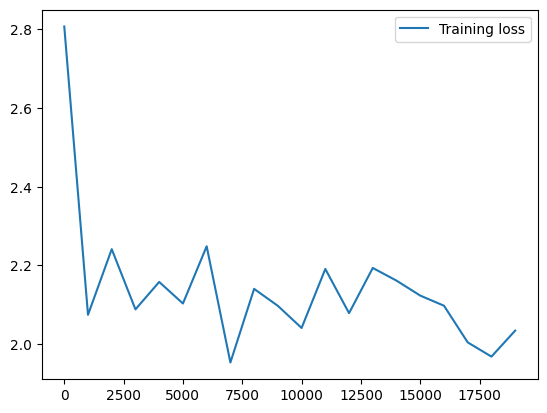

In [16]:
plt.figure()

plt.plot(step, losses, label="Training loss")

plt.legend()

plt.show()

Let's check how the contours look.

In [17]:
fiducial_params = jnp.array([0.0, 0.0])
key, master_key = jax.random.split(master_key)
observation = simulator(key, 1, fiducial_params)

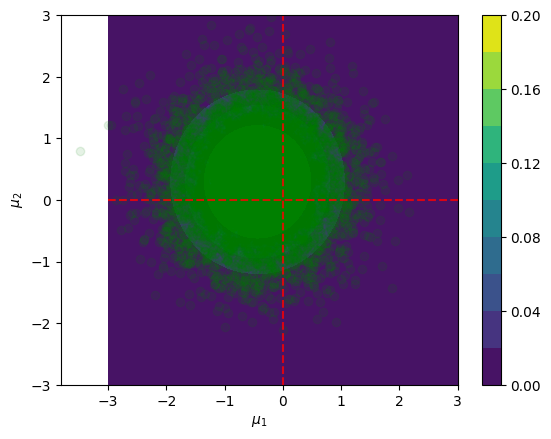

In [18]:
plt.figure()

mu_1 = jnp.linspace(-3, 3, 100)
mu_1, mu_2 = jnp.meshgrid(mu_1, mu_1)

density = jax.vmap(posterior_distribution, in_axes=[0, None])(jnp.stack([mu_1, mu_2], axis=-1).reshape(-1, 2), observation)
density = density.reshape(100, 100)

key, master_key = jax.random.split(master_key)

samples = nf_mlp_compressor.apply(params_nf_mlp, observation, n_samples=10000, rng=key, method="sample")

plt.contourf(mu_1, mu_2, density, levels=10)
plt.colorbar()

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1, color='g', label="Samples")

plt.hlines(fiducial_params[1], -3, 3, color='r', label="True $\mu_2$", ls='--', alpha=0.8)
plt.vlines(fiducial_params[0], -3, 3, color='r', label="True $\mu_1$", ls='--', alpha=0.8)

plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")

plt.show()

Let's now have a look at the latent space of the summary statistics.

In [19]:
params_comp = {'params': params_nf_mlp['params']['mlp_compressor_nn']}
params_nf = {'params': params_nf_mlp['params']['nf_npe_nn']}

In [20]:
key, master_key = jax.random.split(master_key)
observations_latent_space = simulator(key, 10000, fiducial_params)

nf_mlp_compressor_trained = nf_mlp_compressor.bind(params_nf_mlp)
compressor = nf_mlp_compressor_trained.mlp_compressor_nn

z_latent_space = compressor.apply(params_comp, observations_latent_space)

Removed no burn in


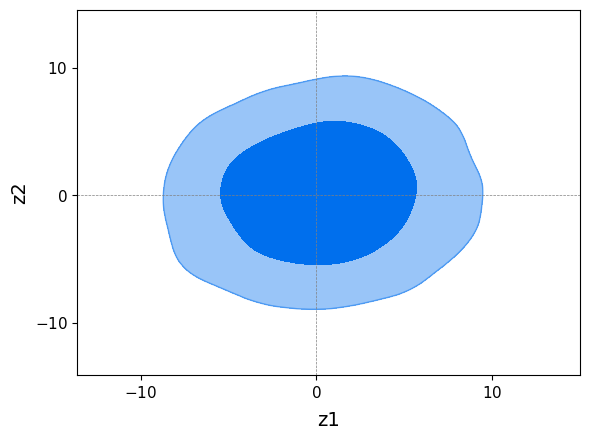

In [21]:
samples_z = MCSamples(
    samples=z_latent_space,
    names=['z1', 'z2']
)

g = plots.get_single_plotter()
g.plot_2d(samples_z, 'z1', 'z2', filled=True)
g.add_x_marker(0.0)
g.add_y_marker(0.0)

plt.show()

We now have to implement the MMD function. We use multiple Gaussian kernels with different bandwidths $\sigma_i$.

In [103]:
MMD_BANDWIDTH_LIST = [
    1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100, 1e3, 1e4, 1e5, 1e6
]

def gaussian_kernel_matrix(x, y, sigmas=None):
    """
    Computes a Gaussian radial basis functions (RBFs) between the samples of x and y.

    We create a sum of multiple Gaussian kernels each having a width sigma_i.

    Parameters
    ----------
    x: array of shape (num_draws_x, num_features)
    y: array of shape (num_draws_y, num_features)
    sigmas: list(float), optional, default: None
        List which denotes the width of each of the Gaussian in the kernel. A default range is used if sigmas is None.
    """
    if sigmas is None:
        sigmas = jnp.array(MMD_BANDWIDTH_LIST)
    norm = lambda v : jnp.sum(v**2, axis=1)
    beta = 1.0 / (2.0 * (jnp.expand_dims(sigmas, 1)))
    dist = jnp.transpose(norm(jnp.expand_dims(x, 2) - jnp.transpose(y)))
    s = jnp.matmul(beta, jnp.reshape(dist, (1, -1)))
    kernel = jnp.reshape(jnp.sum(jnp.exp(-s), axis=0), jnp.shape(dist))
    return kernel

def mmd_kernel(x, y, kernel):
    """
    Computes the Maximum Mean Discrepancy (MMD) between samples of x and y.

    Parameters
    ----------
    x: array of shape (num_draws_x, num_features)
    y: array of shape (num_draws_y, num_features)
    kernel: function
        A kernel function which computes the similarity between two sets of samples.
    """
    return jnp.mean(kernel(x, x)) + jnp.mean(kernel(y, y)) - 2 * jnp.mean(kernel(x, y))

def maximum_mean_discrepancy(source_samples, target_samples, kernel="gaussian", mmd_weight=1.0, minimum=0.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between source and target samples.
    source_samples: samples from the source distribution. Shape: (N, num_features)
    target_samples: samples from the target distribution. Shape: (M, num_features)
    kernel: kernel function to use for the MMD computation. str: "gaussian"
    mmd_weight: weight for the MMD loss. Default: 1.0
    minimum: minimum value for the MMD loss. Default: 0.0
    """
    assert kernel=="gaussian", "Only Gaussian kernel is supported for now"

    if kernel=="gaussian":
        kernel_fun = gaussian_kernel_matrix
    
    loss_value = mmd_kernel(source_samples, target_samples, kernel=kernel_fun)
    loss_value = jnp.maximum(loss_value, minimum)*mmd_weight
    return loss_value

def mmd_summary_space(summary_outputs, rng, z_dist="gaussian", kernel="gaussian"):
    assert z_dist=="gaussian", "Only Gaussian distribution is supported for now"
    assert kernel=="gaussian", "Only Gaussian kernel is supported for now"

    z_samples = jax.random.normal(rng, shape=summary_outputs.shape)
    mmd_loss = maximum_mean_discrepancy(summary_outputs, z_samples, kernel=kernel)
    return mmd_loss

Let's test the implementation of the function by drawing samples from a unit Gaussian.

In [104]:
key, master_key = jax.random.split(master_key)
source_samples = jax.random.normal(key, shape=(1000, 2))
key, master_key = jax.random.split(master_key)
target_samples = jax.random.normal(key, shape=(1000, 2))
key, master_key = jax.random.split(master_key)
target_samples_2 = 10*jax.random.normal(key, shape=(2000, 2))

print(f'Same distribution: {maximum_mean_discrepancy(source_samples, target_samples)}')
print(f'Different distribution: {maximum_mean_discrepancy(source_samples, target_samples_2)}')

Same distribution: 0.013233184814453125
Different distribution: 5.198028564453125


We now define a loss to compress the summary to a unit gaussian and perform the NPE.

In [105]:
def loss_mdd_nll(params, theta, x):
    z = nf_mlp_compressor.apply(params, x, method="compress")
    mmd_loss = mmd_summary_space(z, rng=jax.random.PRNGKey(0))
    log_prob = nf_mlp_compressor.apply(params, theta, z, method="log_prob_from_compressed")
    return -log_prob.mean() + mmd_loss, -log_prob.mean(), mmd_loss

In [106]:
loss_mdd_nll(params_nf_mlp, jnp.ones((2,2)), jnp.ones((2,2)))

(Array(13.377054, dtype=float32),
 Array(2.8379025, dtype=float32),
 Array(10.539152, dtype=float32))

Let's now train our network using the loss with the negative log-likelihood and the maximum mean discrepancy:

In [107]:
loss_fn = lambda params, theta, x: loss_mdd_nll(params, theta, x)[0]

total_steps = 50_000

learning_rate = 1e-3
warmup  = 0.1
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=5e-4,
    peak_value=learning_rate,
    end_value=0.01*learning_rate,
    warmup_steps=warmup,
    decay_steps = int(total_steps * 0.9)
)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_scheduler)
)

opt_state = optimizer.init(params_nf_mlp)

In [108]:
key, master_key = jax.random.split(master_key)
params_nf_mlp, opt_state, loss, step, losses = training_loop(params_nf_mlp, opt_state, total_steps, loss_fn, key)

Step 0, Loss: 4.23
Step 1000, Loss: 2.22
Step 2000, Loss: 2.30
Step 3000, Loss: 2.18
Step 4000, Loss: 2.08
Step 5000, Loss: 2.09
Step 6000, Loss: 2.24
Step 7000, Loss: 2.31
Step 8000, Loss: 2.28
Step 9000, Loss: 2.22
Step 10000, Loss: 2.52
Step 11000, Loss: 2.22
Step 12000, Loss: 2.31
Step 13000, Loss: 2.11
Step 14000, Loss: 2.16
Step 15000, Loss: 2.35
Step 16000, Loss: 2.17
Step 17000, Loss: 2.41
Step 18000, Loss: 1.99
Step 19000, Loss: 2.44
Step 20000, Loss: 2.36
Step 21000, Loss: 2.34
Step 22000, Loss: 2.39
Step 23000, Loss: 2.33
Step 24000, Loss: 2.36
Step 25000, Loss: 2.38
Step 26000, Loss: 2.19
Step 27000, Loss: 2.34
Step 28000, Loss: 2.19
Step 29000, Loss: 2.23
Step 30000, Loss: 2.39
Step 31000, Loss: 2.26
Step 32000, Loss: 2.22
Step 33000, Loss: 2.33
Step 34000, Loss: 2.18
Step 35000, Loss: 2.35
Step 36000, Loss: 2.19
Step 37000, Loss: 2.42
Step 38000, Loss: 2.37
Step 39000, Loss: 2.32
Step 40000, Loss: 2.43
Step 41000, Loss: 2.50
Step 42000, Loss: 2.18
Step 43000, Loss: 2.16
S

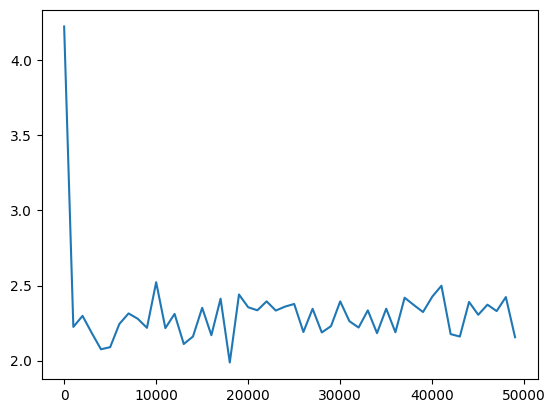

In [109]:
plt.figure()

plt.plot(step, losses, label="Training loss")

plt.show()

In [115]:
key, master_key = jax.random.split(master_key)
theta_batch = prior(key, 100)
key, master_key = jax.random.split(master_key)
x_batch = simulator(key, 100, theta_batch)

mmd_nll_loss, loss_nll_val, mmd_loss = loss_mdd_nll(params_nf_mlp, theta_batch, x_batch)
loss_nll_true = loss_nll(params_nf_mlp, theta_batch, x_batch)
print(f"Loss NLL: {loss_nll_val:.2f}, MMD Loss: {mmd_loss:.2f}, MMD-NLL Loss: {mmd_nll_loss:.2f}")
print(f"True NLL Loss: {loss_nll_true:.2f}")

Loss NLL: 2.30, MMD Loss: 0.11, MMD-NLL Loss: 2.41
True NLL Loss: 2.30


In [116]:
params_comp = {'params': params_nf_mlp['params']['mlp_compressor_nn']}
params_nf = {'params': params_nf_mlp['params']['nf_npe_nn']}

nf_mlp_compressor_trained = nf_mlp_compressor.bind(params_nf_mlp)
compressor = nf_mlp_compressor_trained.mlp_compressor_nn

z_latent_space_mmd = compressor.apply(params_comp, observations_latent_space)

Removed no burn in
Removed no burn in
Removed no burn in


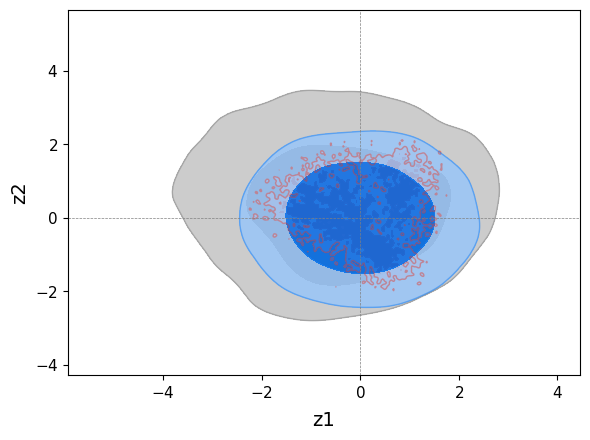

In [117]:
samples_z = MCSamples(
    samples=z_latent_space,
    names=['z1', 'z2']
)
samples_z_mmd = MCSamples(
    samples=z_latent_space_mmd,
    names=['z1', 'z2']
)
samples_gaussian = MCSamples(
    samples=jax.random.normal(jax.random.PRNGKey(0), shape=(10000, 2)),
    names=['z1', 'z2']
)

g = plots.get_single_plotter()
g.plot_2d([samples_z, samples_z_mmd, samples_gaussian], 'z1', 'z2', filled=True)
g.add_x_marker(0.0)
g.add_y_marker(0.0)

plt.show()

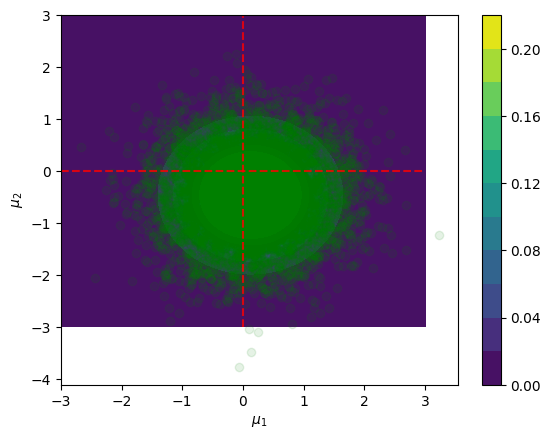

In [120]:
fiducial_params = jnp.array([0.0, 0.0])
key, master_key = jax.random.split(master_key)
observation = simulator(key, 1, fiducial_params)

plt.figure()

mu_1 = jnp.linspace(-3, 3, 100)
mu_1, mu_2 = jnp.meshgrid(mu_1, mu_1)

density = jax.vmap(posterior_distribution, in_axes=[0, None])(jnp.stack([mu_1, mu_2], axis=-1).reshape(-1, 2), observation)
density = density.reshape(100, 100)

key, master_key = jax.random.split(master_key)

samples = nf_mlp_compressor.apply(params_nf_mlp, observation, n_samples=10000, rng=key, method="sample")

plt.contourf(mu_1, mu_2, density, levels=10)
plt.colorbar()

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1, color='g', label="Samples")

plt.hlines(fiducial_params[1], -3, 3, color='r', label="True $\mu_2$", ls='--', alpha=0.8)
plt.vlines(fiducial_params[0], -3, 3, color='r', label="True $\mu_1$", ls='--', alpha=0.8)

plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")

plt.show()